In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import rich.table
import planetary_computer
from pystac_client import Client
import cartopy
from shapely.geometry import Polygon

from IPython.display import Image

## Accessing Sentinel1 RTC data from Planetary Computer

- instructions for finding planetary computer account API key and setting environment vars 
[here](https://github.com/microsoft/PlanetaryComputer/discussions/77)
   

Following instructions from the [S1 RTC Example notebook](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook)

In [2]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

<Client id=microsoft-pc>

Specify time range and bounding box of interest: 

In [3]:
time_range = '2015-01-01/2022-05-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]
bbox_arr = np.array(bbox)
bbox_arr

bbox_coords = [(bbox_arr[0],bbox_arr[1]), 
               (bbox_arr[2],bbox_arr[1]),
               (bbox_arr[2],bbox_arr[3]),
               (bbox_arr[0],bbox_arr[3]),
               (bbox_arr[0],bbox_arr[1])
              ]

#bbox_poly = Polygon(bbox_coords)
#bbox_poly

#bbox_gdf = gpd.GeoDataFrame({'data':['bbox1'], 'geometry' : bbox_poly})
#bbox_gdf.to_file('/Users/emarshall/Desktop/siparcs/xr_book2/s1_bbox1.geojson', driver= 'GeoJSON')


Search for items in the collection you're interested in (here, S1 RTC) matching those parameters. 
Looks like there are 100 scenes in the dataset that match the criteria I specified:

In [4]:
bbox

[88.214935, 27.92767, 88.302, 28.034]

In [5]:
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

100

Convert to geodataframe and explore:

In [6]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
df.head(1)

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:center_frequency,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator
0,"POLYGON ((89.80391 27.02294, 89.82898 27.27428...",2022-04-30T00:03:27.201903Z,SENTINEL-1A,"[27531, 21084]","[530180.0, 2980920.0, 798685.0, 3190410.0]",32645,"[27531, 21084]",2022-04-30 00:03:39.701264+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A


In [7]:
df.explore()

In [9]:
item0 = items[0]
item1 = items[1]

Taking a look at a false color composite from a combination of VV, VH bands from the first item in the `items` list: 

In [11]:
Image(url=item1.assets['rendered_preview'].href)

## Inspect STAC metadata


In [12]:
table = rich.table.Table('key','value')
for k, v in sorted(item0.properties.items()):
    table.add_row(k, str(v))
    
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                        │
│ datetime                              │ 2022-04-30T00:03:27.201903Z                       │
│ end_datetime                          │ 2022-04-30 00:03:39.701264+00:00                  │
│ platform                              │ SENTINEL-1A                                       │
│ proj:bbox                             │ [530180.0, 2980920.0, 798685.0, 3190410.0]        │
│ proj:epsg                             │ 32645                                             │
│ proj:shape                            │ [27531, 21084]                                    │
│ proj:transform                        │ [10.0, 0.0, 524470.0, 0.0, -10.0, 3191680.0, 0.0, │
│                                       │ 0.0, 1.0]                                         │
│ s1:datatake_id                        │ 336414                                            │
│ s1:instrument_configuration_ID        │ 7                                                 │
│ s1:orbit_source                       │ RESORB                                            │
│ s1:processing_level                   │ 1                                                 │
│ s1:product_timeliness                 │ Fast-24h                                          │
│ s1:resolution                         │ high                                              │
│ s1:shape                              │ [27531, 21084]                                    │
│ s1:slice_number                       │ 12                                                │
│ s1:total_slices                       │ 17                                                │
│ sar:center_frequency                  │ 5.405                                             │
│ sar:frequency_band                    │ C                                                 │
│ sar:instrument_mode                   │ IW                                                │
│ sar:looks_azimuth                     │ 1                                                 │
│ sar:looks_equivalent_number           │ 4.4                                               │
│ sar:looks_range                       │ 5                                                 │
│ sar:observation_direction             │ right                                             │
│ sar:pixel_spacing_azimuth             │ 10                                                │
│ sar:pixel_spacing_range               │ 10                                                │
│ sar:polarizations                     │ ['VV', 'VH']                                      │
│ sar:product_type                      │ GRD                                               │
│ sar:resolution_azimuth                │ 22                                                │
│ sar:resolution_range                  │ 20                                                │
│ sat:absolute_orbit                    │ 42995                                             │
│ sat:orbit_state                       │ descending                                        │
│ sat:platform_international_designator │ 2014-016A                                         │
│ sat:relative_orbit                    │ 48                                                │
│ start_datetime                        │ 2022-04-30 00:03:14.702542+00:00                  │
└───────────────────────────────────────┴───────────────────────────────────────────────────┘

In [13]:
item0.properties["sar:polarizations"]

['VV', 'VH']

## Visualize assets

load `vv` data into xarray and plot results. we'll use dask here, see scaling with dask link in example notebook

In [14]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

http://128.117.11.172:8787/status


## stackstac

STAC = Spatio-Temporal Asset Catalog
STAC provides a common framework for describing and cataloging spatiotemporal assets 

STAC objects: 

**STAC Item**
unit representing single spatiotemporal asset as a GeoJSON feature plus datetime and links

**STAC Catalog**
JSON file of links that provides structure to organize, browse **STAC items**

**STAC Collection**
extension of STAC catalog w/ additional info including extents, licenses, keywords metadata etc.

**STAC API**
RESTful endpoint that enables search of STAC items

To load the identified data as xarray objects, we'll use `stackstac` which is a package that facilitates cloud-native raster geoprocessing.

stackstac.stack turns a `stack` collection into a lazy xarray.DataArray backed by dask (from docs)
- transfers STAC metadata to xarray coordinates


In [15]:
type(items)

pystac.item_collection.ItemCollection

Let's take a look at the below command where we build the object `ds`. 

We are calling stackstac.stack() which helps us build an xarray object from the spatiotemporal asset catalog. 

`stackstac.stack()` takes a STAC collection (check this) of STAC items and creates a DataArray of the STAC items reprojected to the same grid and stacked by time. The `items` object can also be a list of python dicts.

Within `stackstac.stack()`, we are calling `planetary_computer.sign()` on the items we identified earlier. This is using the API key associated with your planetary computer account. The other parameters included in `stackstac.stac()` are bounds_latlon, epsg and resolution. 

Providing the `epsg` parameter will return a DataArray reprojected to the epsg code you provide. 

The `resolution` parameter specifies the spatial resolution of the output data array, so the data will be resampled to the provided resolution. Be careful to provide this in the same units as the CRS.

`bounds_latlon` provides the spatial bounding box of the output object in degrees. If we didn't specify a bounds when we create this object, the output would be 15 GB. Clipping it to the bounds we defined above means that it's only 7 mb! 

You can check out all of the parameters that can be included when calling `stackstac.stack()` [here](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)

In [59]:
import stackstac
#bounds_latlon=bbox,
da = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32645, resolution = 50
)
da

,Array,Chunk
Bytes,63.82 MiB,326.76 kiB
Shape,"(100, 2, 239, 175)","(1, 1, 239, 175)"
Count,600 Tasks,200 Chunks
Type,float64,numpy.ndarray


Ran into trying to select by non-dimension coords here. Discussion [here](https://github.com/pydata/xarray/issues/2028) was helpful. Is `.where(..., drop=True)` still the fastest way? 

In [60]:
da = da.assign_coords({'pass_dir': ds['sat:orbit_state']})

In [61]:
da_desc= da.where(da.pass_dir == 'descending', drop=True)
da_desc

,Array,Chunk
Bytes,21.70 MiB,326.76 kiB
Shape,"(34, 2, 239, 175)","(1, 1, 239, 175)"
Count,805 Tasks,68 Chunks
Type,float64,numpy.ndarray


In [62]:
da_asc = da.where(da.pass_dir == 'ascending', drop=True)
da_asc

,Array,Chunk
Bytes,42.12 MiB,326.76 kiB
Shape,"(66, 2, 239, 175)","(1, 1, 239, 175)"
Count,997 Tasks,132 Chunks
Type,float64,numpy.ndarray


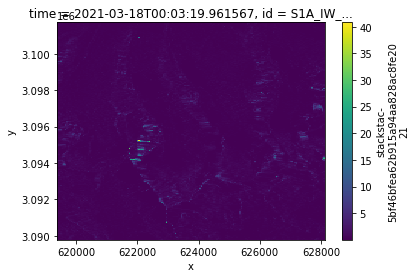

In [63]:
da.sel(band = 'vv').isel(time=2).plot()

In [64]:
da.sel(band='vv').isel(time=2).mean(dim=['x','y']).compute()

<xarray.DataArray 'stackstac-5bf46bfea62b915a94aa828ac8fe2021' ()>
array(0.3914776)
Coordinates:
    time                                   datetime64[ns] 2021-03-18T00:03:19...
    id                                     <U66 'S1A_IW_GRDH_1SDV_20210318T00...
    band                                   <U2 'vv'
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    s1:product_timeliness                  <U8 'Fast-24h'
    start_datetime                         <U32 '2021-03-18 00:03:07.462239+0...
    sar:polarizations                      object {'VV', 'VH'}
    sat:absolute_orbit                     int64 37045
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         <U1 '6'
    s1:total_slices                        <U2 '17'
    sar:looks_equivalent_number            float64 4.4
    sar:pixel_spacing_range                int64 10
    sat:relative_orbit                     int64 48
    s1:resolution                          <U4 'high'
    s1:datatake_id                         <U6 '285734'
    sar:resolution_range                   int64 20
    s1:orbit_source                        <U8 'RESORB'
    sar:frequency_band                     <U1 'C'
    s1:processing_level                    <U1 '1'
    sar:resolution_azimuth                 int64 22
    sar:looks_range                        int64 5
    sar:pixel_spacing_azimuth              int64 10
    proj:epsg                              int64 32645
    sat:platform_international_designator  <U9 '2014-016A'
    platform                               <U11 'SENTINEL-1A'
    constellation                          <U10 'Sentinel-1'
    end_datetime                           <U32 '2021-03-18 00:03:32.460896+0...
    s1:slice_number                        <U2 '12'
    sar:instrument_mode                    <U2 'IW'
    sar:looks_azimuth                      int64 1
    sat:orbit_state                        <U10 'descending'
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
    pass_dir                               <U10 'descending'

units are in intensity scale, convert to dB 

data description [here](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc)

## Cleaning
- polarizations come as coords but we probably want them as vars, worth making a ds? 


In [65]:
#ds = xr.Dataset({'vv': da.sel(band='vv'), 'vh':da.sel(band='vh')},
#              )
#ds

## Groupby seasons

In [66]:
gb_vv = da.sel(band='vv').groupby(da.time.dt.season).mean()
gb_vv

<xarray.DataArray 'stackstac-5bf46bfea62b915a94aa828ac8fe2021' (season: 4, y: 239, x: 175)>
dask.array<stack, shape=(4, 239, 175), dtype=float64, chunksize=(1, 239, 175), chunktype=numpy.ndarray>
Coordinates:
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    s1:product_timeliness                  <U8 'Fast-24h'
    sar:polarizations                      object {'VV', 'VH'}
    sar:center_frequency                   float64 5.405
    sar:looks_equivalent_number            float64 4.4
    sar:pixel_spacing_range                int64 10
    s1:resolution                          <U4 'high'
    sar:resolution_range                   int64 20
    sar:frequency_band                     <U1 'C'
    s1:processing_level                    <U1 '1'
    sar:resolution_azimuth                 int64 22
    sar:looks_range                        int64 5
    sar:pixel_spacing_azimuth              int64 10
    proj:epsg                              int64 32645
    sat:platform_international_designator  <U9 '2014-016A'
    platform                               <U11 'SENTINEL-1A'
    constellation                          <U10 'Sentinel-1'
    sar:instrument_mode                    <U2 'IW'
    sar:looks_azimuth                      int64 1
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
  * season                                 (season) object 'DJF' 'JJA' ... 'SON'

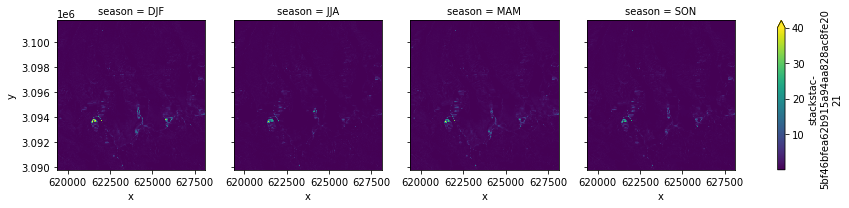

In [67]:
fg_season_vv = gb_vv.plot(col='season', vmax=40)

In [68]:
gb_vh = da.sel(band='vh').groupby(da.time.dt.season).mean()


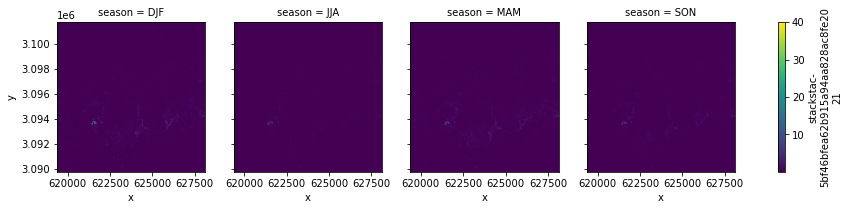

In [69]:
fg_season_vh = gb_vh.plot(col='season', vmax=40)

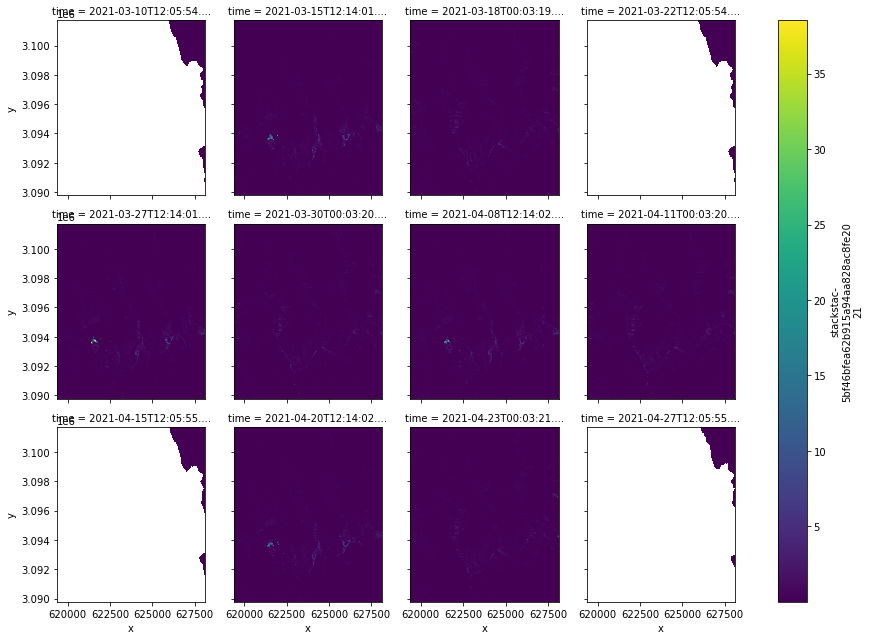

In [70]:
fg = da.sel(band = 'vh').isel(time=slice(0,12)).plot(
    col='time', col_wrap =4)

## Let's try to look at some optical data to see what's going on 

In [71]:
search_opt = catalog.search(collections=["landsat-8-c2-l2"], bbox=bbox, datetime=time_range)
items_opt = search_opt.get_all_items()
len(items_opt)

100

In [72]:
optical_item0 = items_opt[0]
optical_item0

<Item id=LC08_L2SP_139041_20211228_02_T1>

In [73]:
ds_opt = stackstac.stack(
    planetary_computer.sign(items_opt), bounds_latlon=bbox, epsg=32645, resolution = 100
)
ds_opt

,Array,Chunk
Bytes,153.08 MiB,82.50 kiB
Shape,"(100, 19, 120, 88)","(1, 1, 120, 88)"
Count,5700 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [75]:
ds.crs

'epsg:32645'

## Vector data 

Read in vector data to use later

In [76]:
def get_bbox_single(input_xr):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    #print(input_xr.mapping.spatial_epsg)
    #print(f"epsg:{input_xr.mapping.spatial_epsg}")
    #crs = f"epsg:{input_xr.mapping.spatial_epsg}"
    crs = input_xr.crs
    #crs = {'init':f'epsg:{input_xr.mapping.spatial_epsg}'}
    #crs = 'epsg:32645'
    #print(crs)

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon_prj = polygon
    polygon = polygon_prj.to_crs('epsg:4326')

    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]
    
    return polygon_prj

<AxesSubplot:>

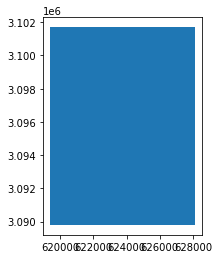

In [77]:
ds_bbox = get_bbox_single(ds)
ds_bbox.plot()

In [78]:
rgi = gpd.read_file('https://github.com/scottyhq/rgi/raw/main/15_rgi60_SouthAsiaEast.gpkg')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, ds_bbox, how='inner')

`rgi_sub` should be all glaciers within the s1 bbox

In [79]:
rgi_sub.explore()

In [80]:
ds_vv = ds.sel(band='vv')
ds_vh = ds.sel(band='vh')
ds_vv

<xarray.DataArray 'stackstac-bf1444433bc8ccae728f0fd7ab5b6f06' (time: 100, y: 120, x: 88)>
dask.array<getitem, shape=(100, 120, 88), dtype=float64, chunksize=(1, 120, 88), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2021-03-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    s1:product_timeliness                  <U8 'Fast-24h'
    start_datetime                         (time) <U32 '2021-03-10 12:05:41.6...
    sar:polarizations                      object {'VV', 'VH'}
    sat:absolute_orbit                     (time) int64 36936 37009 ... 42995
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    s1:total_slices                        (time) <U2 '21' '20' ... '20' '17'
    sar:looks_equivalent_number            float64 4.4
    sar:pixel_spacing_range                int64 10
    sat:relative_orbit                     (time) int64 114 12 48 ... 114 12 48
    s1:resolution                          <U4 'high'
    s1:datatake_id                         (time) <U6 '284776' ... '336414'
    sar:resolution_range                   int64 20
    s1:orbit_source                        (time) <U8 'PREORB' ... 'RESORB'
    sar:frequency_band                     <U1 'C'
    s1:processing_level                    <U1 '1'
    sar:resolution_azimuth                 int64 22
    sar:looks_range                        int64 5
    sar:pixel_spacing_azimuth              int64 10
    proj:epsg                              int64 32645
    sat:platform_international_designator  <U9 '2014-016A'
    platform                               <U11 'SENTINEL-1A'
    constellation                          <U10 'Sentinel-1'
    end_datetime                           (time) <U32 '2021-03-10 12:06:06.6...
    s1:slice_number                        (time) <U2 '6' '6' '12' ... '6' '12'
    sar:instrument_mode                    <U2 'IW'
    sar:looks_azimuth                      int64 1
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'ascending' ... 'desce...
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(619400, 3089700, 628200, 3101...
    crs:         epsg:32645
    transform:   | 100.00, 0.00, 619400.00|\n| 0.00,-100.00, 3101700.00|\n| 0...
    resolution:  100

## Convert power scale to decibel 

RTC data is processed by Planetary Computer as intensity values (gamma-nought). This is good for statistical analysis but not great for visualizing (from ASF [docs](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/)) so let's convert from gamma-nought to sigma-nought (replace for symbols). 

intensity values (linear-scale) dominated by a few bright pixels. dB (log-scale) shows the variablity in intensity. 

In [81]:
ds_vv

<xarray.DataArray 'stackstac-bf1444433bc8ccae728f0fd7ab5b6f06' (time: 100, y: 120, x: 88)>
dask.array<getitem, shape=(100, 120, 88), dtype=float64, chunksize=(1, 120, 88), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2021-03-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    s1:product_timeliness                  <U8 'Fast-24h'
    start_datetime                         (time) <U32 '2021-03-10 12:05:41.6...
    sar:polarizations                      object {'VV', 'VH'}
    sat:absolute_orbit                     (time) int64 36936 37009 ... 42995
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    s1:total_slices                        (time) <U2 '21' '20' ... '20' '17'
    sar:looks_equivalent_number            float64 4.4
    sar:pixel_spacing_range                int64 10
    sat:relative_orbit                     (time) int64 114 12 48 ... 114 12 48
    s1:resolution                          <U4 'high'
    s1:datatake_id                         (time) <U6 '284776' ... '336414'
    sar:resolution_range                   int64 20
    s1:orbit_source                        (time) <U8 'PREORB' ... 'RESORB'
    sar:frequency_band                     <U1 'C'
    s1:processing_level                    <U1 '1'
    sar:resolution_azimuth                 int64 22
    sar:looks_range                        int64 5
    sar:pixel_spacing_azimuth              int64 10
    proj:epsg                              int64 32645
    sat:platform_international_designator  <U9 '2014-016A'
    platform                               <U11 'SENTINEL-1A'
    constellation                          <U10 'Sentinel-1'
    end_datetime                           (time) <U32 '2021-03-10 12:06:06.6...
    s1:slice_number                        (time) <U2 '6' '6' '12' ... '6' '12'
    sar:instrument_mode                    <U2 'IW'
    sar:looks_azimuth                      int64 1
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'ascending' ... 'desce...
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(619400, 3089700, 628200, 3101...
    crs:         epsg:32645
    transform:   | 100.00, 0.00, 619400.00|\n| 0.00,-100.00, 3101700.00|\n| 0...
    resolution:  100

In [82]:
sigma_n_vv = (10*np.log10(np.abs(ds_vv)))
sigma_n_vh = (10*np.log10(np.abs(ds_vh)))
sigma_n_vv

<xarray.DataArray 'stackstac-bf1444433bc8ccae728f0fd7ab5b6f06' (time: 100, y: 120, x: 88)>
dask.array<mul, shape=(100, 120, 88), dtype=float64, chunksize=(1, 120, 88), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2021-03-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    s1:product_timeliness                  <U8 'Fast-24h'
    start_datetime                         (time) <U32 '2021-03-10 12:05:41.6...
    sar:polarizations                      object {'VV', 'VH'}
    sat:absolute_orbit                     (time) int64 36936 37009 ... 42995
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    s1:total_slices                        (time) <U2 '21' '20' ... '20' '17'
    sar:looks_equivalent_number            float64 4.4
    sar:pixel_spacing_range                int64 10
    sat:relative_orbit                     (time) int64 114 12 48 ... 114 12 48
    s1:resolution                          <U4 'high'
    s1:datatake_id                         (time) <U6 '284776' ... '336414'
    sar:resolution_range                   int64 20
    s1:orbit_source                        (time) <U8 'PREORB' ... 'RESORB'
    sar:frequency_band                     <U1 'C'
    s1:processing_level                    <U1 '1'
    sar:resolution_azimuth                 int64 22
    sar:looks_range                        int64 5
    sar:pixel_spacing_azimuth              int64 10
    proj:epsg                              int64 32645
    sat:platform_international_designator  <U9 '2014-016A'
    platform                               <U11 'SENTINEL-1A'
    constellation                          <U10 'Sentinel-1'
    end_datetime                           (time) <U32 '2021-03-10 12:06:06.6...
    s1:slice_number                        (time) <U2 '6' '6' '12' ... '6' '12'
    sar:instrument_mode                    <U2 'IW'
    sar:looks_azimuth                      int64 1
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'ascending' ... 'desce...

<AxesSubplot:title={'center':'time = 2021-03-18T00:03:19.961567, id = S1A_IW_...'}, xlabel='x', ylabel='y'>

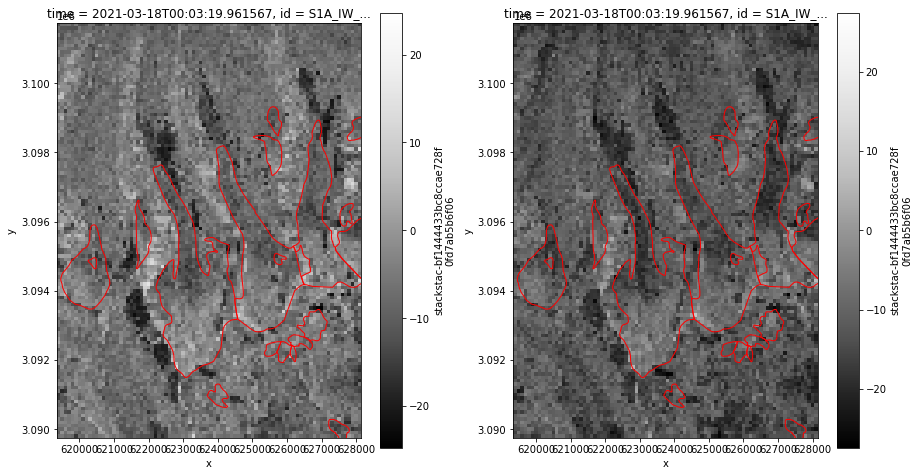

In [85]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))

sigma_n_vv.isel(time=2).plot(ax=axs[0], cmap=plt.cm.Greys_r)
rgi_sub.plot(edgecolor='r', facecolor='none', ax=axs[0])
sigma_n_vh.isel(time=2).plot(ax=axs[1], cmap=plt.cm.Greys_r)
rgi_sub.plot(edgecolor='red', facecolor='none', ax=axs[1])
